# What's Up Zoc?
What's Up Zoc is an end-to-end product to help users find a better doctor.
## Preprocessing of reviews
After scraping the data and storing them in a csv file, the reviews are preprocessed to be feeded into LDA topic modeling.

In [1]:
# Importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
#nltk.download()

In [8]:
# Read the scraped data
df = pd.read_pickle("df_cleaned.pkl")
df.head()

,doctor,doctor_type,name,rating,text
0,"Dr. Paul Chrzanowski, MD",Pulmonologist,"Norma R., verified patient","5,5,5",Excellent and caring doctor. He is very helpfu...
1,"Dr. Paul Chrzanowski, MD",Pulmonologist,"Richard T., verified patient","5,5,5",Very approachable and insightful
2,"Dr. Paul Chrzanowski, MD",Pulmonologist,"Julie J., verified patient","5,5,5","Great doctor! Thoughtful, kind, thorough, smart."
3,"Dr. Paul Chrzanowski, MD",Pulmonologist,"Andrew U., verified patient","5,5,5",Dr. Chrzanowski is always polite and shows tha...
4,"Dr. Paul Chrzanowski, MD",Pulmonologist,"Richard T., verified patient","5,5,5","Very good, he’s very helpful, approachable, kn..."


In [3]:
# Break down the reviews into sentences
from nltk.tokenize import sent_tokenize
sent_list = []
num_revs = []
for doc in df.doctor.unique():
    sent_list.append(df.loc[df.doctor == doc, "text"].apply(lambda x: sent_tokenize(x)).values)
    num_revs.append((doc, df.loc[df.doctor == doc, "text"].apply(lambda x: len(sent_tokenize(x))).values.sum()))

In [4]:
# Now that the reviews are broken down into sentences, the doctor names should be associated with each sentence as opposed to each review which was the case before breaking down the reviews
import itertools
df_sent = pd.DataFrame(columns = ["doctor", "sentences"])
merged = list(itertools.chain(*itertools.chain(*sent_list)))
df_sent["sentences"] = pd.Series(merged)

In [5]:
lst = []
for _, val in enumerate(num_revs):
    lst.append(list(itertools.repeat(val[0], val[1])))

In [6]:
merged = list(itertools.chain(*lst))
df_sent["doctor"] = pd.Series(merged)

In [7]:
df_sent.head()

,doctor,sentences
0,"Dr. Paul Chrzanowski, MD",Excellent and caring doctor.
1,"Dr. Paul Chrzanowski, MD",He is very helpful and knowledgeable.
2,"Dr. Paul Chrzanowski, MD",Very approachable and insightful
3,"Dr. Paul Chrzanowski, MD",Great doctor!
4,"Dr. Paul Chrzanowski, MD","Thoughtful, kind, thorough, smart."


In [10]:
df_sent.shape

(162470, 2)

In [11]:
# save df_sent
# df_sent.to_pickle("df_sent.pkl")

In [11]:
# Remove Doctors' names as they will not be helpful in finding topics
import re
def removeDrsNames(df):
    df["sent_noDrs"] = df["sentences"].apply(lambda x: re.sub(r'dr.\s*([^\s]+)', '', x.lower()))
    df["sent_noDrs"] = df["sent_noDrs"].apply(lambda x: re.sub(r'dr\s*([^\s]+)', '', x.lower()))
    df["sent_noDrs"] = df["sent_noDrs"].apply(lambda x: re.sub(r'doctor\s*([^\s]+)', '', x.lower()))
    df["sent_noDrs"] = df["sent_noDrs"].apply(lambda x: re.sub(r'doc\s*([^\s]+)', '', x.lower()))
    df["sent_noDrs"] = df["sent_noDrs"].apply(lambda x: re.sub(r'docs\s*([^\s]+)', '', x.lower()))
    return df

df_sent = removeDrsNames(df_sent)

In [12]:
df_sent.head()

,doctor,sentences,sent_noDrs
0,"Dr. Paul Chrzanowski, MD",Excellent and caring doctor.,excellent and caring
1,"Dr. Paul Chrzanowski, MD",He is very helpful and knowledgeable.,he is very helpful and knowledgeable.
2,"Dr. Paul Chrzanowski, MD",Very approachable and insightful,very approachable and insightful
3,"Dr. Paul Chrzanowski, MD",Great doctor!,great
4,"Dr. Paul Chrzanowski, MD","Thoughtful, kind, thorough, smart.","thoughtful, kind, thorough, smart."


- Remove new line chars
- Break sentences into words (tokenize)
- remove stopwords

In [13]:
import gensim
from gensim.utils import simple_preprocess
stopword_set = frozenset(nltk.corpus.stopwords.words('english'))
def strip_newline(series):
    return [review.replace('\n','') for review in series]
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopword_set] \
            for doc in texts]
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [14]:
words = sent_to_words(df_sent.sent_noDrs)
words = remove_stopwords(words)
bigram = bigrams(words)
bigram = [bigram[review] for review in words]

convert the list of tokens into a series and add it to the dataframe

In [15]:
df_sent["tokens"] = pd.Series(words)

Detect adjectives using POS (Part of Speach taggging) and Remove them as they are not helpful in finding topics. They should be considered in the sentiment analysis step though.

In [16]:
pos_tags = df_sent["tokens"].apply(lambda x: nltk.pos_tag(x))

In [17]:
pos_tags.head()

0                      [(excellent, JJ), (caring, NN)]
1                 [(helpful, NN), (knowledgeable, JJ)]
2               [(approachable, JJ), (insightful, NN)]
3                                        [(great, JJ)]
4    [(thoughtful, JJ), (kind, NN), (thorough, IN),...
Name: tokens, dtype: object

In [18]:
# Remove adjectives
pos_tags = pos_tags.apply(lambda x: [item[0] for item in x if item[1] not in ["JJ", "JJR", "JJS"]])

__Lemmatization__

In [19]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
df_sent["lemmatized"] = pos_tags.apply(lambda x : [lemmatizer.lemmatize(i, pos = 'v') for i in x])

In [20]:
df_sent.head()

,doctor,sentences,sent_noDrs,tokens,lemmatized
0,"Dr. Paul Chrzanowski, MD",Excellent and caring doctor.,excellent and caring,"[excellent, caring]",[care]
1,"Dr. Paul Chrzanowski, MD",He is very helpful and knowledgeable.,he is very helpful and knowledgeable.,"[helpful, knowledgeable]",[helpful]
2,"Dr. Paul Chrzanowski, MD",Very approachable and insightful,very approachable and insightful,"[approachable, insightful]",[insightful]
3,"Dr. Paul Chrzanowski, MD",Great doctor!,great,[great],[]
4,"Dr. Paul Chrzanowski, MD","Thoughtful, kind, thorough, smart.","thoughtful, kind, thorough, smart.","[thoughtful, kind, thorough, smart]","[kind, thorough, smart]"


# LDA Topic Modeling

gensim's LDA Mallet is used for LDA topic modeling

In [23]:
mallet_path = '~/Desktop/mallet-2.0.8/bin/mallet'

Building the dictionary and the corpus

In [21]:
id2word_mallet = gensim.corpora.Dictionary(df_sent.lemmatized)
corpus_mallet = [id2word_mallet.doc2bow(text) for text in df_sent.lemmatized]

__Finding the best number of topics__

using elbow method, the model with the highest coherence value is chosen as the final LDA model. 

In [153]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Don't forget the set the seed.
        model = gensim.models.wrappers.LdaMallet(mallet_path, \
                                                 corpus = corpus, num_topics = num_topics, \
                                                 id2word = dictionary, \
                                                random_seed = 101)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [154]:
# start building LDA Mallet models with number of topics in the range of 2 and 20, and step size of 3.
model_list, coherence_values = compute_coherence_values(dictionary = id2word_mallet,\
                                                                  corpus = corpus_mallet, \
                                                        texts= df_sent.lemmatized, \
                                                                    start=2, limit=20, step=3)

/Users/mahsa/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


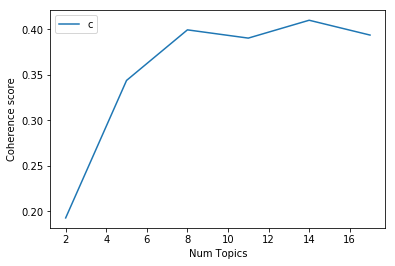

In [155]:
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [156]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1928
Num Topics = 5  has Coherence Value of 0.3437
Num Topics = 8  has Coherence Value of 0.3992
Num Topics = 11  has Coherence Value of 0.3902
Num Topics = 14  has Coherence Value of 0.4098
Num Topics = 17  has Coherence Value of 0.3935


The difference between coherence values of the 8-topic model and the 14-topic model is not significant by any means. Looking at word contents of each topic for each of these models, the model with 8 number of topics provides stronger semantic similarity between the contributing words.

In [157]:
# Select model 4 (the model with 14 number of topics) and print the topics
from pprint import pprint
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.160*"care" + 0.076*"clean" + 0.067*"patients" + 0.042*"health" + '
  '0.039*"eye" + 0.037*"exam" + 0.035*"teeth" + 0.029*"person" + '
  '0.023*"wonderful" + 0.014*"contact"'),
 (1,
  '0.170*"explain" + 0.132*"time" + 0.049*"understand" + 0.043*"things" + '
  '0.035*"detail" + 0.034*"talk" + 0.027*"procedure" + 0.023*"step" + '
  '0.020*"history" + 0.020*"job"'),
 (2,
  '0.091*"appointment" + 0.064*"work" + 0.057*"call" + 0.051*"back" + '
  '0.043*"test" + 0.037*"result" + 0.037*"day" + 0.029*"schedule" + '
  '0.028*"follow" + 0.023*"appointments"'),
 (3,
  '0.334*"recommend" + 0.233*"highly" + 0.035*"practice" + 0.030*"experience" '
  '+ 0.029*"family" + 0.029*"friends" + 0.021*"continue" + 0.020*"place" + '
  '0.015*"dermatologist" + 0.011*"refer"'),
 (4,
  '0.268*"time" + 0.186*"wait" + 0.070*"minutes" + 0.040*"room" + '
  '0.037*"appointment" + 0.029*"long" + 0.029*"hour" + 0.025*"bite" + '
  '0.023*"walk" + 0.020*"spend"'),
 (5,
  '0.168*"office" + 0.073*"amaze" + 0.068*"

In [158]:
# Select model 2 (the model with 8 number of topics) and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.171*"time" + 0.105*"question" + 0.097*"explain" + 0.049*"answer" + '
  '0.044*"treatment" + 0.029*"patient" + 0.028*"understand" + 0.024*"things" + '
  '0.022*"lot" + 0.021*"options"'),
 (1,
  '0.148*"make" + 0.121*"feel" + 0.057*"manner" + 0.053*"felt" + 0.040*"visit" '
  '+ 0.037*"bedside" + 0.035*"rush" + 0.025*"talk" + 0.025*"leave" + '
  '0.022*"ease"'),
 (2,
  '0.122*"care" + 0.060*"concern" + 0.055*"give" + 0.053*"listen" + '
  '0.052*"issue" + 0.038*"patients" + 0.026*"problem" + 0.025*"patient" + '
  '0.024*"health" + 0.021*"treat"'),
 (3,
  '0.178*"office" + 0.167*"staff" + 0.073*"kind" + 0.072*"friendly" + '
  '0.048*"professional" + 0.040*"extremely" + 0.030*"helpful" + '
  '0.025*"efficient" + 0.022*"pleasant" + 0.022*"nice"'),
 (4,
  '0.106*"wait" + 0.072*"appointment" + 0.060*"time" + 0.040*"minutes" + '
  '0.031*"call" + 0.027*"insurance" + 0.026*"check" + 0.023*"room" + '
  '0.020*"day" + 0.017*"fill"'),
 (5,
  '0.190*"recommend" + 0.132*"highly" + 0.084*"exp

The 8-topic model is chosen as the final LDA model. Let's find the dominant topic for each sentence.

In [159]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_mallet, texts = df_sent.lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/mahsa/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1422,"care, concern, give, listen, issue, patients, ...",[care]
1,1,3.0,0.1422,"office, staff, kind, friendly, professional, e...",[helpful]
2,2,7.0,0.1422,"visit, amaze, love, excellent, service, eye, e...",[insightful]
3,3,0.0,0.1250,"time, question, explain, answer, treatment, pa...",[]
4,4,2.0,0.1394,"care, concern, give, listen, issue, patients, ...","[kind, thorough, smart]"
5,5,2.0,0.1528,"care, concern, give, listen, issue, patients, ...","[always, polite, show, truly, care, patients]"
6,6,0.0,0.1830,"time, question, explain, answer, treatment, pa...","[make, feel, ask, question, ensure, explain, t..."
7,7,6.0,0.1548,"back, work, clean, pain, test, result, forward...","[also, take, care, things, like, blood, sample]"
8,8,5.0,0.1384,"recommend, highly, experience, dentist, find, ...","[thankful, stumble, practice, neighborhood]"
9,9,3.0,0.1422,"office, staff, kind, friendly, professional, e...","[helpful, etc]"


In [28]:
# Save the final state of all the dataframes up to this point
# df_dominant_topic.to_pickle("df_dominant_topic.pkl")
# df_sent.to_pickle("df_sent_lemmatized.pkl")

In [ ]:
# df_dominant_topic = pd.read_pickle("df_dominant_topic.pkl")

Removing sentences with 100/8 percentage of contribution as the topic contribution is equal for all the topics, and hence no dominant topic can be detected for such sentences

In [29]:
df_topicScores = df_sent.loc[df_dominant_topic["Topic_Perc_Contrib"] > (100/8/100)]
df_dominant_topic = df_dominant_topic[df_dominant_topic["Topic_Perc_Contrib"] > 100/8/100]

In [30]:
df_topicScores.head()

,doctor,sentences,sent_noDrs,tokens,lemmatized
0,"Dr. Paul Chrzanowski, MD",Excellent and caring doctor.,excellent and caring,"[excellent, caring]",[care]
1,"Dr. Paul Chrzanowski, MD",He is very helpful and knowledgeable.,he is very helpful and knowledgeable.,"[helpful, knowledgeable]",[helpful]
2,"Dr. Paul Chrzanowski, MD",Very approachable and insightful,very approachable and insightful,"[approachable, insightful]",[insightful]
4,"Dr. Paul Chrzanowski, MD","Thoughtful, kind, thorough, smart.","thoughtful, kind, thorough, smart.","[thoughtful, kind, thorough, smart]","[kind, thorough, smart]"
5,"Dr. Paul Chrzanowski, MD",Dr. Chrzanowski is always polite and shows tha...,is always polite and shows that he truly care...,"[always, polite, shows, truly, cares, patients]","[always, polite, show, truly, care, patients]"


In [31]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1422,"care, concern, give, listen, issue, patients, ...",[care]
1,1,3.0,0.1422,"office, staff, kind, friendly, professional, e...",[helpful]
2,2,7.0,0.1422,"visit, amaze, love, excellent, service, eye, e...",[insightful]
4,4,2.0,0.1394,"care, concern, give, listen, issue, patients, ...","[kind, thorough, smart]"
5,5,2.0,0.1528,"care, concern, give, listen, issue, patients, ...","[always, polite, show, truly, care, patients]"


# Sentiment Analysis
Now that we have the dominant topic per sentence, we can find most positive and negative sentences per topic

In [32]:
# Using NLTK's Vader sentiment analysis tool
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df_dominant_topic[["neg", "neu", "pos", "compound"]]= df_topicScores["sentences"].apply(lambda x: sid.polarity_scores(x)).apply(pd.Series)
df_dominant_topic["sentences"] = df_topicScores["sentences"]
df_dominant_topic["doctor"] = df_topicScores["doctor"]

In [37]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,neg,neu,pos,compound,sentences,doctor
0,0,2.0,0.1422,"care, concern, give, listen, issue, patients, ...",[care],0.0,0.225,0.775,0.7845,Excellent and caring doctor.,"Dr. Paul Chrzanowski, MD"
1,1,3.0,0.1422,"office, staff, kind, friendly, professional, e...",[helpful],0.0,0.618,0.382,0.4754,He is very helpful and knowledgeable.,"Dr. Paul Chrzanowski, MD"
2,2,7.0,0.1422,"visit, amaze, love, excellent, service, eye, e...",[insightful],0.0,1.000,0.000,0.0000,Very approachable and insightful,"Dr. Paul Chrzanowski, MD"
4,4,2.0,0.1394,"care, concern, give, listen, issue, patients, ...","[kind, thorough, smart]",0.0,0.103,0.897,0.8271,"Thoughtful, kind, thorough, smart.","Dr. Paul Chrzanowski, MD"
5,5,2.0,0.1528,"care, concern, give, listen, issue, patients, ...","[always, polite, show, truly, care, patients]",0.0,0.670,0.330,0.7096,Dr. Chrzanowski is always polite and shows tha...,"Dr. Paul Chrzanowski, MD"


__ Retrieving 3 most positive and 3 most negative sentences with respect to each topic __

Extracting the top 3 positive and negative sentences from each topic

In [35]:
#df_topicScores["dominant_topic"] = df_dominant_topic["Dominant_Topic"]

In [39]:
WT_top3pos = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    WT_top3pos = pd.concat([WT_top3pos, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 4.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] >= 0.1) & (df_dominant_topic["neg"] == 0.0)]\
                                         .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences", "dominant_topic"]]])

/Users/mahsa/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [40]:
WT_top3pos.head()

,doctor,sentences,dominant_topic
126,"Dr. Paul Chrzanowski, MD",Dr. Chrzanowski was so nice and I was called b...,NaN
47,"Dr. Paul Chrzanowski, MD","Dr. C is communicative, thorough, gentle and w...",NaN
121,"Dr. Paul Chrzanowski, MD",I think this is what doctors must have been li...,NaN
390,"Dr. Monica Schadlow, MD",I'm fine with waiting but when I've already fi...,NaN
235,"Dr. Monica Schadlow, MD","First, how responsive the office was when I ca...",NaN


In [42]:
WT_top3neg = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    WT_top3neg = pd.concat([WT_top3neg, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 4.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] < 0.1) & \
                                                                                   (df_dominant_topic["neg"] != 0.0)]\
                                         .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])

In [44]:
staff_top3pos = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    staff_top3pos = pd.concat([staff_top3pos, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 3.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] >= 0.1) & (df_dominant_topic["neg"] == 0.0)]\
                                         .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])
    

staff_top3neg = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    staff_top3neg = pd.concat([staff_top3neg, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 3.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] < 0.1) & (df_dominant_topic["neg"] != 0.0)]\
                                                                 .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])

In [45]:
BM_top3pos = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    BM_top3pos = pd.concat([BM_top3pos, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 1.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] >= 0.1) & (df_dominant_topic["neg"] == 0.0)]\
                                         .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])
    

BM_top3neg = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    BM_top3neg = pd.concat([BM_top3neg, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 1.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] < 0.1) & (df_dominant_topic["neg"] != 0.0)]\
                                                                 .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])

In [46]:
care_top3pos = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    care_top3pos = pd.concat([care_top3pos, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 2.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] >= 0.1) & (df_dominant_topic["neg"] == 0.0)]\
                                         .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])
    

care_top3neg = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    care_top3neg = pd.concat([care_top3neg, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 2.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] < 0.1) & (df_dominant_topic["neg"] != 0.0)]\
                                                                 .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])

In [47]:
resp_top3pos = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    resp_top3pos = pd.concat([resp_top3pos, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 0.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] >= 0.1) & (df_dominant_topic["neg"] == 0.0)]\
                                         .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])
    

resp_top3neg = pd.DataFrame()
for i in df_topicScores.doctor.unique():
    resp_top3neg = pd.concat([resp_top3neg, df_dominant_topic.loc[df_dominant_topic.loc[(df_dominant_topic.Dominant_Topic == 0.0) & (df_topicScores.doctor == i) &\
                      (df_dominant_topic["compound"] < 0.1) & (df_dominant_topic["neg"] != 0.0)]\
                                                                 .nlargest(3, 'Topic_Perc_Contrib').index, ["doctor", "sentences"]]])

Finding the percentage of people recommending each doctor per topic

In [198]:
for i in df_topicScores.doctor.unique():
    freq = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 4.0) & \
                               (df_dominant_topic["compound"] >= 0.05), "compound"]
    total = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 4.0),\
                                        "compound"]
    WT_top3pos.loc[WT_top3pos.doctor == i, "avg_recomm"] = freq.count()/total.count()

/Users/mahsa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [199]:
for i in df_topicScores.doctor.unique():
    freq = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 3.0) & \
                               (df_dominant_topic["compound"] >= 0.05), "compound"]
    total = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 3.0),\
                                        "compound"]
    staff_top3pos.loc[staff_top3pos.doctor == i, "avg_recomm"] = freq.count()/total.count()

/Users/mahsa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [200]:
for i in df_topicScores.doctor.unique():
    freq = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 2.0) & \
                               (df_dominant_topic["compound"] >= 0.05), "compound"]
    total = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 2.0),\
                                        "compound"]
    care_top3pos.loc[care_top3pos.doctor == i, "avg_recomm"] = freq.count()/total.count()

/Users/mahsa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [201]:
for i in df_topicScores.doctor.unique():
    freq = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 1.0) & \
                               (df_dominant_topic["compound"] >= 0.05), "compound"]
    total = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 1.0),\
                                        "compound"]
    BM_top3pos.loc[BM_top3pos.doctor == i, "avg_recomm"] = freq.count()/total.count()

/Users/mahsa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [202]:
for i in df_topicScores.doctor.unique():
    freq = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 0.0) & \
                               (df_dominant_topic["compound"] >= 0.05), "compound"]
    total = df_dominant_topic.loc[(df_dominant_topic.doctor == i) & (df_dominant_topic.Dominant_Topic == 0.0),\
                                        "compound"]
    resp_top3pos.loc[resp_top3pos.doctor == i, "avg_recomm"] = freq.count()/total.count()

/Users/mahsa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [48]:
# Save all these to have access to retrieve info for Chrome Extension
#WT_top3pos.to_pickle("WT_top3pos.pkl")
#WT_top3neg.to_pickle("WT_top3neg.pkl")
#staff_top3pos.to_pickle("staff_top3pos.pkl")
#staff_top3neg.to_pickle("staff_top3neg.pkl")
#BM_top3pos.to_pickle("BM_top3pos.pkl")
#BM_top3neg.to_pickle("BM_top3neg.pkl")
#care_top3pos.to_pickle("care_top3pos.pkl")
#care_top3neg.to_pickle("care_top3neg.pkl")
#resp_top3pos.to_pickle("resp_top3pos.pkl")
#resp_top3neg.to_pickle("resp_top3neg.pkl")